In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import Parallel, delayed
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv("text.csv") 
X = data['text']
y = data['label']

In [3]:
def remove_outliers(text_data, min_len=5, max_len=280, alpha_ratio=0.5):
    """
    Removes outliers from the text data based on text length and character composition.
    """
    def is_outlier(text):
        if len(text) < min_len or len(text) > max_len:
            return True
        alpha_count = len(re.findall(r'[a-zA-Z]', text))
        return alpha_count / max(len(text), 1) < alpha_ratio

    return text_data[~text_data.apply(is_outlier)]

# Sequential outlier removal
start_time = time.time()
filtered_text = remove_outliers(X)
filtered_data = data[data['text'].isin(filtered_text)]
outlier_removal_time = time.time() - start_time

# Update X and y with filtered data
X_filtered = filtered_data['text']
y_filtered = filtered_data['label']

print(f"Outlier Removal Time (Sequential): {outlier_removal_time:.2f} seconds")


Outlier Removal Time (Sequential): 8.63 seconds


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Sequential Data Preprocessing
start_time = time.time()
vectorizer = TfidfVectorizer(max_features=1000)
X_vect = vectorizer.fit_transform(X_filtered)
data_preprocessing_time = time.time() - start_time

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y_filtered, test_size=0.2, random_state=42)

print(f"Data Preprocessing Time (Sequential): {data_preprocessing_time:.2f} seconds")


Data Preprocessing Time (Sequential): 13.42 seconds


Best Logistic Regression Parameters: {'C': 10, 'max_iter': 1000, 'solver': 'liblinear'}
Best Naive Bayes Parameters: {'alpha': 0.1}
Logistic Regression Results:
Training Time: 61.70 seconds
Prediction Time: 0.06 seconds
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1 Score: 0.86



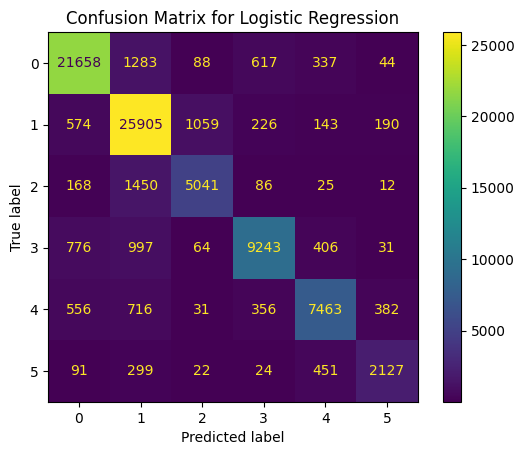

Naive Bayes Results:
Training Time: 0.15 seconds
Prediction Time: 0.02 seconds
Accuracy: 0.82
Precision: 0.84
Recall: 0.82
F1 Score: 0.81



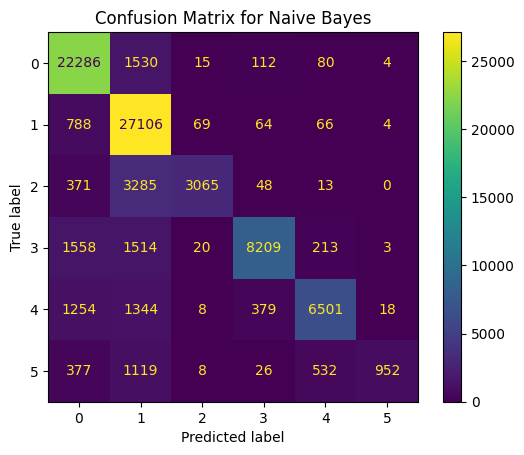

In [6]:
# Hyperparameter tuning using GridSearchCV
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Logistic Regression hyperparameter tuning
logistic_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}
logistic_model = LogisticRegression()
# Sample a smaller subset (e.g., 10% of the data) for hyperparameter tuning
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# Perform hyperparameter tuning using the smaller dataset
best_logistic_model, best_logistic_params = hyperparameter_tuning(logistic_model, logistic_param_grid, X_train_sample, y_train_sample)
print("Best Logistic Regression Parameters:", best_logistic_params)

# Naive Bayes hyperparameter tuning
naive_bayes_param_grid = {
    'alpha': [0.1, 1.0, 10.0]
}
naive_bayes_model = MultinomialNB()

# Perform hyperparameter tuning using the smaller dataset
best_naive_bayes_model, best_naive_bayes_params = hyperparameter_tuning(naive_bayes_model, naive_bayes_param_grid, X_train_sample, y_train_sample)
print("Best Naive Bayes Parameters:", best_naive_bayes_params)

# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Measure prediction time
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print results
    print(f"{model_name} Results:")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Prediction Time: {prediction_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Train and evaluate best Logistic Regression model (outside of the function)
train_and_evaluate_model(best_logistic_model, X_train, X_test, y_train, y_test, "Logistic Regression")

# Train and evaluate best Naive Bayes model (outside of the function)
train_and_evaluate_model(best_naive_bayes_model, X_train, X_test, y_train, y_test, "Naive Bayes")
